In [1]:
########################LLAMA SECTION##########################

In [2]:
%%capture
!pip install unsloth

In [3]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.1.5: Fast Mllama vision patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [4]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3443,
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


In [5]:
from datasets import load_dataset
dataset = load_dataset("philschmid/amazon-product-descriptions-vlm",
                       split = "train[0:500]")


dataset

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1345 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'Uniq Id', 'Product Name', 'Category', 'Selling Price', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Variants', 'Product Url', 'Is Amazon Seller', 'description'],
    num_rows: 500
})

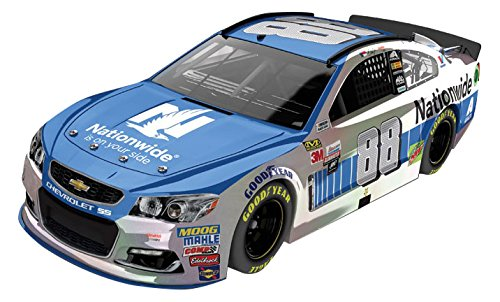

In [6]:
dataset[45]["image"]

In [7]:
dataset[45]["description"]

'Authentic Dale Earnhardt Jr. 1:24 scale diecast car. Nationwide Raw Finish.  Collectible model car for racing fans.  Perfect gift for NASCAR enthusiasts.'

In [8]:
instruction = """
You are an expert Amazon worker who is good at writing product descriptions.
Write the product description accurately by looking at the image.
"""


def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["description"]}],
        },
    ]
    return {"messages": conversation}


pass


converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [9]:
converted_dataset[45]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': '\nYou are an expert Amazon worker who is good at writing product descriptions. \nWrite the product description accurately by looking at the image.\n'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x302>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Authentic Dale Earnhardt Jr. 1:24 scale diecast car. Nationwide Raw Finish.  Collectible model car for racing fans.  Perfect gift for NASCAR enthusiasts.'}]}]}

In [10]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[45]["image"]

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ],
    }
]
input_text = tokenizer.apply_chat_template(
    messages, add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)

The image showcases a race car featuring the well-known sponsorship branding "Nationwide," likely the primary vehicle in the Nationwide Series. The vehicle has a blue hood with the "Nationwide" logo prominently displayed and white text that reads, "on your side," on the windscreen. The car is predominantly white and grey, adorned with sponsor decals on various parts of the vehicle.

The front grille showcases the Chevrolet "Bowtie" logo, denoted as "SS," indicating that it is the Chevrolet SS model. Additionally, the car is emblazoned with the number 88 in white, which is typically the number of Dale Earnhardt


In [11]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)  # Enable for training!

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),  # Must use!
    train_dataset=converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=30,
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=5,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",  # For Weights and Biases
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

In [12]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 500 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 67,174,400
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,3.199800
10,2.071600
15,1.309600
20,1.169800
25,1.081700
30,1.094000


In [13]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[45]["image"]

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ],
    }
]
input_text = tokenizer.apply_chat_template(
    messages, add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)

Bring the magic of NASCAR to your desk with the 1/24th Scale NASCAR Collectible Die-Cast Vehicle!  This exquisite 88 Nationwide Chevrolet SS model by Action Racing Collectables is precision crafted for detail.  Perfect for collectors, this miniature masterpiece captures the thrill of racing.  #NASCAR #DieCast #Collectibles #ScaleModel #HotWheels #ActionRacingCollectables  #88Nationwide<|eot_id|>


In [21]:
from huggingface_hub import login
import os
hf_token = os.environ['HF_TOKEN']
login(hf_token)

In [22]:
model.save_pretrained("llama_3.2_vision_amazon_product") # Local saving
tokenizer.save_pretrained("llama_3.2_vision_amazon_product")

[]

In [23]:
model.push_to_hub(
    "aesat/llama_3.2_vision_amazon_product"
)  # Online saving
tokenizer.push_to_hub(
    "aesat/llama_3.2_vision_amazon_product"
)  # Online saving

README.md:   0%|          | 0.00/628 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

Saved model to https://huggingface.co/aesat/llama_3.2_vision_amazon_product


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]